# HMM Для прогнозирования

Для повышения точности прогнозов важно понимать, что разные модели прогнозирования подходят для разных временных рядов с разными характеристиками.

К сожалению, нет одной модели, которая бы подошла для расчета прогноза для всех ситуаций - типов временных рядов

Какие характеристики временных рядов можно выделить:

1. Сезонность:

   Полные ряды – когда данные есть минимум за 1 полный цикл, т.е. минимум за 12 месяцев, или за 4 квартала и можно выделить        сезонность;

   Неполный ряд – когда данных еще нет за полный цикл;
   

2. Рост:

    Временной ряд с ростом, когда можно выделить явный рост продаж от года к году.

      Рост может быть постоянный;

      Рост может быть затухающий;

      Рост может быть экспоненциальный;

      Рост может меняться падением;

     Статичный временной ряд – это временной ряд, который не содержит роста;
     

3. Важность тенденций для прогноза:

     Для прогноза могут быть важны тенденции за длительный период;

      Для прогноза могут быть важны тенденции за последний период;
      

4. Не регулярные, разовые продажи.


У нас есть набор различных параметров временных рядов. Данные параметры для одного временного ряда будут сочетаться между собой. Например,

        Временной ряд может быть полный с ростом и тенденциями за длительный период;

        Временной ряд может быть полный статичный с тенденциями за последний период;

        неполный с ростом и тенденциями за последний период.
        
        
При описании временных рядов регрессионными моделями обычно предполагается, что параметры моделей не изменяются на интервале наблюдения. Вместе с тем, например, экономические временные ряды часто демонстрируют нестационарное поведение, которое может быть обусловлено экономическими спадами, финансовыми кризисами, технологическими изменениями, положительными и отрицательными новостями и другими событиями. 

Если изменения
происходят в случайные моменты времени, то для адекватного описания могут быть использованы модели со скачкообразными изменениями параметров и с переключениями режимов работы


HMMlearn - библиотека с открытым исходным кодом, которая состоит из простых алгоритмов и моделей для изучения скрытых марковских моделей (HMM) в Python



http://scikit-learn.sourceforge.net/stable/modules/hmm.html

In [20]:
pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

# Модели временных рядов с переключениями

Обозначим $s_t$ ненаблюдаемую переменную состояния, принимающую значения 0 или 1. Простейшая модель переключения для переменной $z_t$ состоит из двух спецификаций типа AR:

$z_t = \begin{cases} \alpha_0 + \beta z_{t-1} + \epsilon_t, & s_t = 0 \\ \alpha_0 + \alpha_1 + \beta z_{t-1} + \epsilon_t, & s_t = 1 \end{cases}$
 
где $|\beta|<1$ и $\epsilon_t$ независимые одинаково распределённые случайные величины с нулевым средним и дисперсией $\sigma^2_\epsilon$.

In [45]:
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1.
beta = .05
s = np.random.binomial(n=1, p=0.8, size=100)
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps

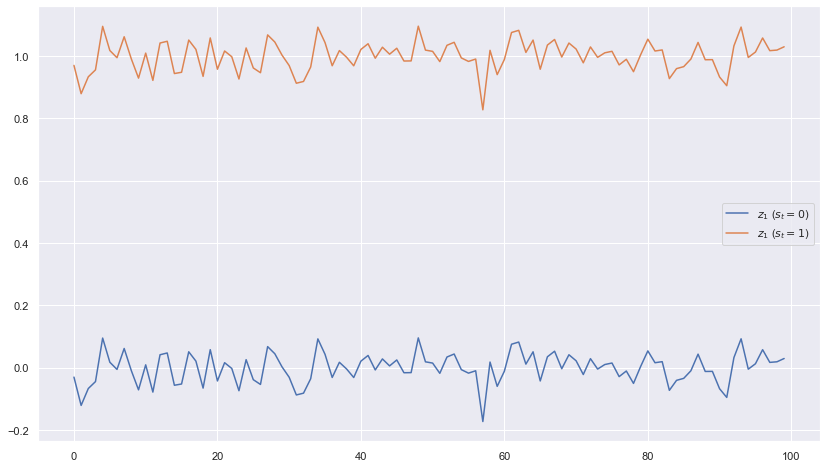

In [23]:
plt.figure(figsize=(14,8))
plt.plot(z1, label='$z_1$ ($s_t = 0$)')
plt.plot(z2, label='$z_1$ ($s_t = 1$)')
plt.legend()
plt.show()

In [47]:

z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

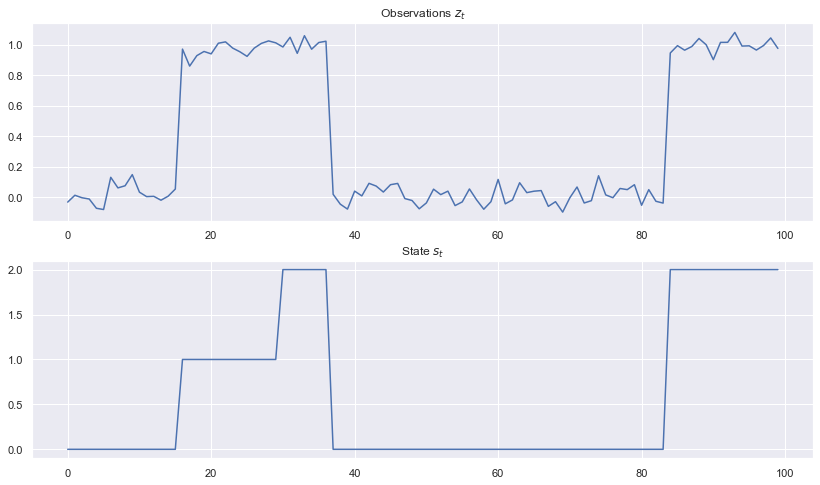

In [44]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

Это стационарный AR(1) процесс со средним $\dfrac{\alpha_0}{1-\beta}$ при $s_t=0$ и переключающийся на другой стационарный AR(1) процесс со средним $\dfrac{\alpha_0+\alpha_1}{1-\beta}$, когда $s_t$ переключается с 0 на 1.

- если $a_1 \ne 0$: два динамических паттерна в зависимости от значения переменной состояния $s_t$;
- в этом случае $z_t$ управляется двумя распределениями с разным средним;
- переменная $s_t$ отвечает за переключение между этими распределениями (режимами).

Только что показанный пример: $s_t \sim Bern(p),p=0.8$.

В этой модели $s_t$ не зависит от предыдущих и будущих реализаций, поэтому $z_t$ может сильно "прыгать" (часто переключаться между разными состояниями).

## Что такое модель с марковским переключением?

Пусть, как раньше,

$z_t = \begin{cases} \alpha_0 + \beta z_{t-1} + \epsilon_t, & s_t = 0 \\ \alpha_0 + \alpha_1 + \beta z_{t-1} + \epsilon_t, & s_t = 1 \end{cases}$

Обозначим $s_t$ ненаблюдаемую переменную состояния, принимающую значения 0 или 1 согласно марковской цепи первого порядка:

$P=\begin{pmatrix} P(s_t=0|s_{t-1}=0) & P(s_t=1|s_{t-1}=0 \\ P(s_t=0|s_{t-1}=1) & P(s_t=1|s_{t-1}=1 \end{pmatrix} = \begin{pmatrix} p_{00} & p_{01} \\ p_{10} & p_{11} \end{pmatrix}$

где за $p_{ij},i,j∈\{0,1\}$ обозначена вероятность перехода в состояние $s_t=j$ из состояния $s_{i−1}=i$.

- Матрица перехода управляет случайным поведением переменной состояния и зависит только от двух параметров ($p00$
 и $p11$).
- Модель такого типа называют моделью с марковскими переключениями.
- Свойства $z_t$ определяются характеристиками распределения как $\epsilon_t$, так и переменной состояния $s_t$.
- В частности, марковская переменная состояния приводит к случайным и частым сменам режима, а вероятности перехода определяют персистентность каждого из режимов.

Важный факт: распределение наблюдений обусловлено ненаблюдаемой переменной состояния:
$Law(z_t)=Law(z_t|s_t)$

Например:
- $Law(z_t|s_t=0) = N(\dfrac{\alpha_0}{1-\beta}, \sigma_\epsilon^2)$
- $Law(z_t|s_t=1) = N(\dfrac{\alpha_0 + \alpha_1}{1-\beta}, \sigma_\epsilon^2)$

# Как сгенерировать траекторию модели с марковскими переключениями?

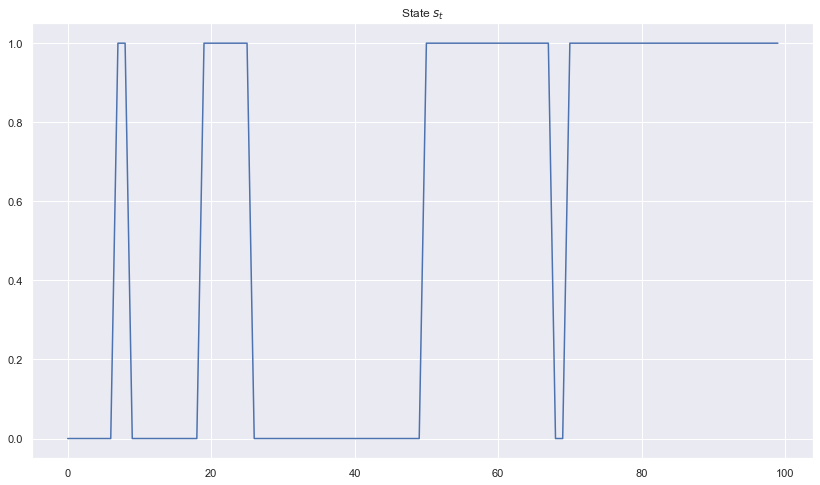

In [52]:
# 1. Генерирование марковской цепи с 2 скрытыми состояниями
P = np.array([
    [0.95, 0.05],
    [0.05, 0.95],
])
s = [0]
for t in range(99):
    distribution = P[s[-1]]
    s.append(np.random.choice([0, 1], p=distribution))

f, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
axs.plot(s)
axs.set_title('State $s_t$')
plt.show()

In [53]:
# 2. Генерирование наблюдений из распределений, обусловленных ненаблюдаемым состоянием
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1.
beta = .05
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps
z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

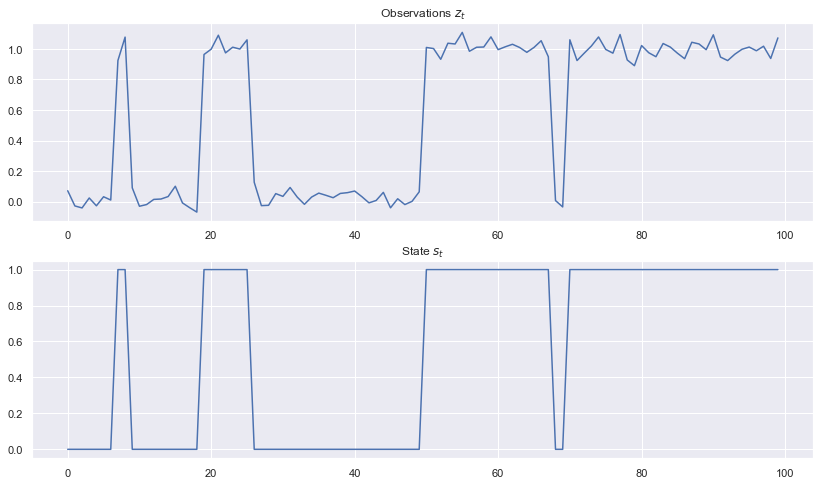

In [54]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

Основные задачи теории скрытых марковских процессов:
    
- **Обучение с учителем**. Пусть есть некоторая последовательность $X$, для которой известны латентные переменные $T$. По обучающей выборке нужно оценить набор параметров $\Theta$.
- **Сегментация**. Пусть известна последовательность наблюдаемых переменных $X$ и набор параметров $\Theta$. По ним нужно построить максимально правдоподобный набор латентных переменных $T$, то есть найти $argmax_T p(T∣X,\Theta)$.
- **Обучение без учителя**. Пусть известна последовательность наблюдаемых переменных $X$ и число состояний $K$. Нужно оценить набор параметров $\Theta$. Подзадача - **нахождение маргинального распределения**: найти $p(t_n∣X,\Theta)$.
- **Прогнозирование**. Пусть известна некоторая последовательность X длины N. Нужно оценить наблюдаемый вектор в момент времени $N+1$, то есть найти $p(x_{N+1}∣X)$.

# Как сгенерировать траекторию скрытой марковской модели?

In [126]:
import numpy as np
from hmmlearn import hmm
np.random.seed(42)

model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(100)

No handles with labels found to put in legend.


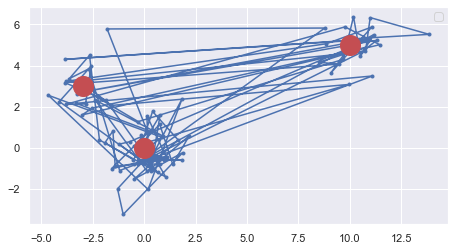

In [127]:
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
_ = axs.plot(X[:, 1], X[:, 0], '.-')
_ = axs.plot(model.means_[:, 1], model.means_[:, 0], 'ro', ms=20)
_ = axs.legend()
axs.set_aspect('equal')

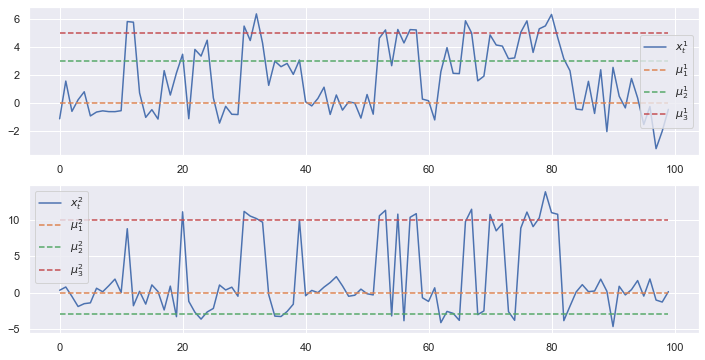

In [128]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
_ = axs[0].plot(X[:, 0], label='$x^1_t$')
for i in range(3):
    _ = axs[0].plot(range(len(X)), model.means_[i, 0] * np.ones(len(X)), '--', label='$\mu^1_{}$'.format(i+1))
_ = axs[0].legend()

_ = axs[1].plot(X[:, 1], label='$x^2_t$')
for i in range(3):
    _ = axs[1].plot(range(len(X)), model.means_[i, 1] * np.ones(len(X)), '--', label='$\mu^2_{}$'.format(i+1))
_ = axs[1].legend()

# Прогноз с использованием HMM

Загрузка скрытого гауссовского класса модели Маркова

In [61]:
from hmmlearn.hmm import GaussianHMM

In [65]:
series = pd.read_csv("daily-total-female-births-in-cal.csv")["Count"]

In [66]:
series

0      35
1      32
2      30
3      31
4      44
5      29
6      45
7      43
8      38
9      27
10     38
11     33
12     55
13     47
14     45
15     37
16     50
17     43
18     41
19     52
20     34
21     53
22     39
23     32
24     37
25     43
26     39
27     35
28     44
29     38
       ..
335    32
336    46
337    41
338    34
339    33
340    36
341    49
342    43
343    43
344    34
345    39
346    35
347    52
348    47
349    52
350    39
351    40
352    42
353    42
354    53
355    39
356    40
357    38
358    44
359    34
360    37
361    52
362    48
363    55
364    50
Name: Count, Length: 365, dtype: int64

In [78]:
values = series.values.reshape(-1,1)

In [79]:
values

array([[35],
       [32],
       [30],
       [31],
       [44],
       [29],
       [45],
       [43],
       [38],
       [27],
       [38],
       [33],
       [55],
       [47],
       [45],
       [37],
       [50],
       [43],
       [41],
       [52],
       [34],
       [53],
       [39],
       [32],
       [37],
       [43],
       [39],
       [35],
       [44],
       [38],
       [24],
       [23],
       [31],
       [44],
       [38],
       [50],
       [38],
       [51],
       [31],
       [31],
       [51],
       [36],
       [45],
       [51],
       [34],
       [52],
       [47],
       [45],
       [46],
       [39],
       [48],
       [37],
       [35],
       [52],
       [42],
       [45],
       [39],
       [37],
       [30],
       [35],
       [28],
       [45],
       [34],
       [36],
       [50],
       [44],
       [39],
       [32],
       [39],
       [45],
       [43],
       [39],
       [31],
       [27],
       [30],
       [42],
       [46],

Cоздадим  и обучим гауссовский HMM. Функция этого класса требует в качестве входных данных число скрытых состояний, число итераций для запуска из алгоритма Baum-Welch

In [ ]:
Первым шагом в прогнозировании является обучение HMM для вычисления параметров из данной последовательности наблюдений. 
Как найти оптимальное количество скрытых состояний?

In [87]:
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -1245.3909354932182
2 -1231.414547976922
3 -1228.6376241958374
4 -1222.4806144371257
5 -1214.0832255520315
6 -1210.507472370257
7 -1200.8310217305886
8 -1191.217146662642
9 -1173.4784597582413
10 -1160.5670529092515
11 -1147.5330967603065
12 -1140.3509173996456
13 -1133.8680670390759


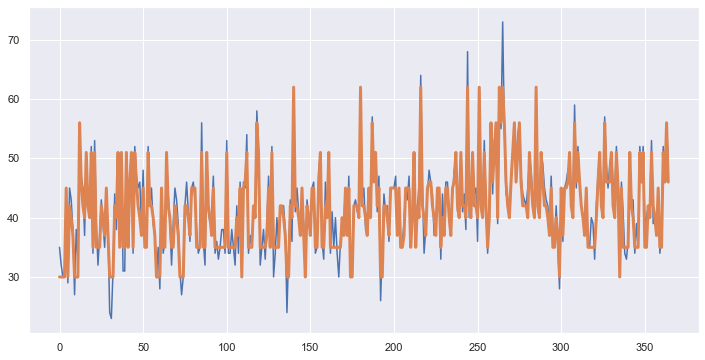

In [88]:
model = GaussianHMM(n_components=10,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

In [89]:
model.transmat_.shape

(10, 10)

In [93]:
print(model.transmat_)

[[2.51351644e-001 4.29429222e-002 1.88714004e-044 8.25667818e-014
  4.29048778e-010 3.87382481e-002 6.66945611e-001 1.41732268e-041
  2.15722564e-005 1.81588653e-009]
 [2.17442677e-023 2.54498442e-001 1.62023366e-020 3.54802690e-018
  1.10071856e-001 3.19143175e-001 7.91202039e-002 5.09990650e-066
  1.04389460e-001 1.32776862e-001]
 [7.07913891e-001 9.45366092e-003 6.26753612e-093 2.94215764e-044
  4.50660623e-129 5.88092209e-129 1.71014693e-051 2.82632448e-001
  1.04511298e-079 1.66437305e-238]
 [3.10749206e-001 4.93494373e-002 1.40069554e-102 6.57000399e-036
  1.03990966e-016 4.04961942e-001 5.66967004e-033 7.70477704e-002
  1.57891644e-001 3.51674135e-059]
 [2.36755747e-019 7.41727072e-001 5.57998035e-006 2.08595829e-028
  2.22571231e-011 8.01269756e-011 2.18484086e-015 4.86345117e-007
  2.67182699e-024 2.58266861e-001]
 [8.64721523e-002 5.12581238e-008 1.11740354e-094 1.61889246e-001
  2.57313442e-002 5.92246998e-001 1.01865304e-001 5.88148023e-026
  3.17949048e-002 5.89959265e-022

# Материалы

- http://quantile.ru/11/11-CK.pdf

# Домашнее задание

- [Выберите ряд](https://datamarket.com/data/list/?q=cat:fpg%20provider:tsdl) и оцените его через HMM. 